## Fine Tune NER Model

To fine-tune a Named Entity Recognition (NER) model to extract key entities (products, prices, and location) from Amharic Telegram messages, we will follow these steps.

**Step 1:** Set Up Environment with GPU Support

- Use Google Colab or GPU-Enabled Environment Ensure that selected a runtime with GPU in Google Colab:

  - Go to Runtime > Change runtime type > Select GPU.
  
- Install Necessary Libraries
  - Run the following commands in a code cell to install the required libraries:

In [20]:
# Uncomment below line, and run the cell
#!pip install pyarrow==10.0.1 datasets==2.4.0 seqeval


- Import necessary libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import XLMRobertaTokenizerFast
from datasets import Dataset, Features, Sequence, Value
from transformers import TrainingArguments
from transformers import XLMRobertaForTokenClassification, AutoModelForTokenClassification, AutoTokenizer, Trainer


Once the required libraries are installed, we will use transformers for the model and datasets for loading data, and seqeval for evaluating the NER model.

**Step 2:** Load the Labeled Dataset from CoNLL File
- Load the CoNLL Dataset
  - we can load our CoNLL formatted data into a DataFrame. Here's how we can do that:

In [72]:
# Function to load CoNLL formatted data
def load_conll(file_path):
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        sentence = []
        label = []
        for line in f:
            if line.strip():  # Non-empty line
                token, label_item = line.split()
                sentence.append(token)
                label.append(label_item)
            else:  # Empty line indicates end of a sentence
                sentences.append(sentence)
                labels.append(label)
                sentence = []
                label = []
    return pd.DataFrame({'tokens': sentences, 'labels': labels})

# Load your CoNLL file
df = load_conll('/kaggle/input/labeled-dataset/labeled_data_conll.conll')


In [73]:
# Explore the first few rows
df.head()

,tokens,labels
0,"[ይህን, መፍጫ, ከሁሉም, የተሻለ, ሆኖ, አግኝተነዋል, 1, አስተማማኝ,...","[O, B-PRODUCT, O, O, O, O, O, O, O, O, O, O, O..."
1,"[ማጂክ, መወልወያ, ውሃ, በከፍተኛ, ደረጃ, ይመጣል, በራሱ, ይጨምቃል,...","[O, B-PRODUCT, O, O, O, O, O, O, O, O, O, B-PR..."
2,"[ባለ1, እና, ባለ, 2, ተች, ስቶቭ, ግዜዎን, እና, ጉልበትዎን, የሚ...","[O, O, O, O, O, B-PRODUCT, O, O, O, O, O, B-PR..."
3,"[ሶስት, ፍሬ, የዳቦ, እና, የኬክ, ቅርጽ, ማውጫ, መጋገሪያ, ትራ, ት...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[360, የሚዞር, በቀላሉ, የውሃ, ቱቦ, ላይ, የሚገጠም, ለመኪና, እጥ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


**Define Unique Labels:**
- Extract unique labels from the DataFrame and create a mapping from labels to IDs.

In [74]:
unique_labels = set(label for sublist in df['labels'] for label in sublist)
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}


In [25]:
unique_labels

{'B-LOCATION', 'B-PRICE', 'B-PRODUCT', 'I-PRICE', 'I-PRODUCT', 'O'}

In [75]:
df['labels'] = df['labels'].apply(lambda x: [label2id[label] for label in x])


**Step 3:** Convert DataFrame to Hugging Face Dataset

In [27]:
# Convert DataFrame to Hugging Face Dataset
# Make sure 'labels' is a list of lists
# Define the features with the correct data types
features = Features({
    'tokens': Sequence(Value('string')),  # List of strings for tokens
    'labels': Sequence(Value('int32'))    # List of integers for labels
})

# Convert DataFrame to Hugging Face Dataset with specified features
dataset = Dataset.from_pandas(df[['tokens', 'labels']], features=features)

**Step 4:** Tokenization and Label Alignment

 - Ensure Consistent Tokenization Across Models: Since we're comparing different models, make sure that the tokenization for each model is compatible with its architecture. 
- Tokenization functions for **XLM-Roberta**, **DistilBERT**, and **mBERT** can vary, so we need to adapt the tokenization for each mode



- Tokenize and align label for XLM-ROBERTA

In [ ]:
# Initialize the Fast Tokenizer
# Use the fast tokenizer
# For XLM-Roberta
tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    "xlm-roberta-base",
    clean_up_tokenization_spaces=True
    )

# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        truncation=True, 
        is_split_into_words=True, 
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )
    
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Tokenize the dataset using xlrm_berta

tokenized_xlm_dataset = dataset.map(tokenize_and_align_labels, batched=True)


- Tokenize and align for mbert

In [ ]:
# For mBERT
tokenizer_mbert = AutoTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_mbert(
        examples['tokens'], 
        truncation=True, 
        is_split_into_words=True, 
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )
    
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Tokenize the dataset using xlrm_berta

tokenized_mbert_dataset = dataset.map(tokenize_and_align_labels, batched=True)


- Tokenize and align label for DistilBERT


In [ ]:
#Tokenize the dataset using DistilBERT
# For DistilBERT
tokenizer_distilbert = AutoTokenizer.from_pretrained(
    'distilbert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_distilbert(
        examples['tokens'], 
        truncation=True, 
        is_split_into_words=True, 
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )
    
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

tokenized_distilbert_dataset = dataset.map(tokenize_and_align_labels, batched=True)


- Split the dataset into train and test data of each tokenized dataset

In [32]:
# Split into train and validation datasets
train_test_split_xlm = tokenized_xlm_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_mbert = tokenized_mbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_distilbert = tokenized_distilbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation


**Step 5:** Set Up Training Arguments

- Configure common training arguments for all models.

In [34]:
# Set up training arguments with adjustments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",     # Evaluates at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # Strength of weight decay
    max_grad_norm=1.0,  # Gradient clipping
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="steps",        # Log at regular intervals
    logging_steps=50,                # Log every 50 steps
    save_strategy="epoch",           # Save model at the end of each epoch
    report_to="none",                # Only show logs in the output (no TensorBoard)
    use_cpu=True,  # Force training to happen on CPU,
    load_best_model_at_end=True,     # Load the best model (based on metric) at the end
    metric_for_best_model="eval_loss",# Metric used to determine the best model
    save_total_limit=1,              # Only keep the best model, delete the others
    
)


**Step 6:** Load and Fine-Tune the pre-trained model

- Use Hugging Face Trainer API

Fine-tune the model using the Trainer API.

- fine-tune each of the following pre-trained models:

- `xlm-roberta-base`

- `DistilBERT`

- `mBERT`

In [35]:
# Initialize each of the models
# For XLM-Roberta
model_xlmr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(unique_labels)) # Ensure unique_labels is defined

# For DistilBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(unique_labels))

# For mBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(unique_labels))



Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Set Up Trainer for Each Model

- Define a custom `compute_metrics` function to calculate precision, recall, and F1-score using `scikit-learn` and pass it to the Trainer of each model.


In [36]:
# Define the function to compute evaluation metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [[label for label in label_row if label != -100] for label_row in labels]
    predicted_labels = [[pred for pred, true in zip(pred_row, true_row) if true != -100] for pred_row, true_row in zip(predictions, labels)]

    # Flatten the lists
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    predicted_labels_flat = [item for sublist in predicted_labels for item in sublist]

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=True)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [37]:
trainer_xlmr = Trainer(
    model=model_xlmr,
    args=training_args,
    train_dataset=train_test_split_xlm['train'],
    eval_dataset=train_test_split_xlm['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_mbert['train'],
    eval_dataset=train_test_split_mbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)
trainer_mbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_distilbert['train'],
    eval_dataset=train_test_split_distilbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)

**Step 8:** Train, Evaluate and Compare Model Results:

- After training all three models, evaluate them using metrics such as F1-score, Precision, Recall, and Accuracy. 
- Train each model

In [38]:
# Fine-tune XLM-Roberta
print('For XLM-Roberta')
trainer_xlmr.train()

# Fine-tune DistilBERT
print('For DistilBERT')
trainer_distilbert.train()


# Fine-tune mBERT
print('For mBERT')
trainer_mbert.train()


For XLM-Roberta


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.366200,0.045816,0.991837,0.991706,0.989956
2,0.041900,0.018782,0.994195,0.994076,0.992319
3,0.023800,0.015324,0.994193,0.994076,0.992647


For DistilBERT


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.299800,0.161489,0.949384,0.951413,0.946738
2,0.174500,0.118412,0.966497,0.968040,0.965168
3,0.143800,0.111428,0.969130,0.969887,0.966861


For mBERT


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.135700,0.115306,0.966166,0.967920,0.963640
2,0.117100,0.103023,0.967952,0.969494,0.965683
3,0.101600,0.099357,0.969484,0.970872,0.967015


TrainOutput(global_step=165, training_loss=0.11656415606990005, metrics={'train_runtime': 1057.6847, 'train_samples_per_second': 2.468, 'train_steps_per_second': 0.156, 'total_flos': 170502299550720.0, 'train_loss': 0.11656415606990005, 'epoch': 3.0})


- Use the Trainer’s `evaluate()` method to get the results of  the evaluation metrics for each model, and compare them side-by-side to determine which one performs the best for the NER Model


- Visualize the evaluation result to better understand

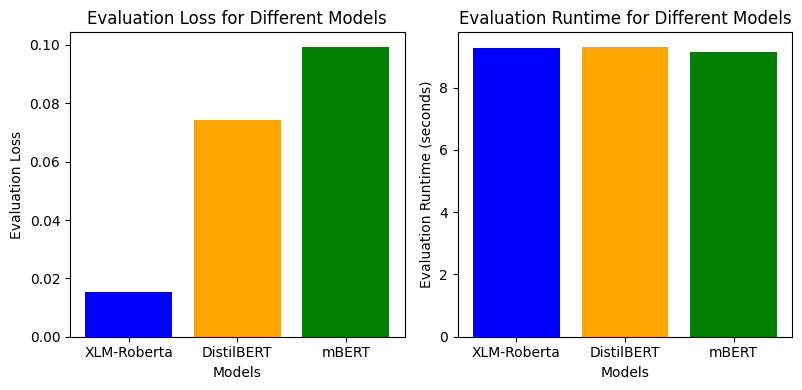

In [39]:
# Create a dictionary to hold the results
results = {}

# Evaluate each model and store the results
results['XLM-Roberta'] = trainer_xlmr.evaluate()
results['DistilBERT'] = trainer_distilbert.evaluate()
results['mBERT'] = trainer_mbert.evaluate()

# Extracting the relevant metrics
eval_loss = [results[model]['eval_loss'] for model in results]
eval_runtime = [results[model]['eval_runtime'] for model in results]
samples_per_second = [results[model]['eval_samples_per_second'] for model in results]

# Visualization for Evaluation Loss
plt.figure(figsize=(12, 4))

# Plotting Evaluation Loss
plt.subplot(1, 3, 1)
plt.bar(results.keys(), eval_loss, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss for Different Models')

# Plotting Evaluation Runtime
plt.subplot(1, 3, 2)
plt.bar(results.keys(), eval_runtime, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Evaluation Runtime (seconds)')
plt.title('Evaluation Runtime for Different Models')

# Plotting Samples Per Second
# plt.subplot(1, 3, 3)
# plt.bar(results.keys(), samples_per_second, color=['blue', 'orange', 'green'])
# plt.xlabel('Models')
# plt.ylabel('Samples Per Second')
# plt.title('Samples Per Second for Different Models')

plt.tight_layout()
plt.show()



- Visualize the result


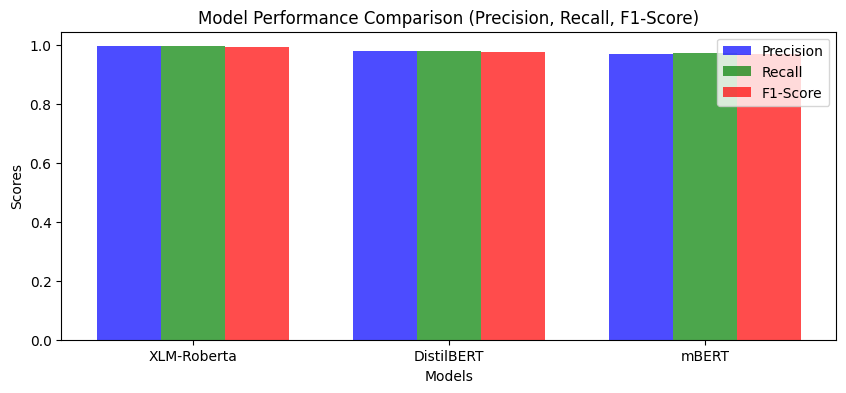

In [40]:
# Extract data
models = list(results.keys())
precision_scores = [results[model]['eval_precision'] for model in models]
recall_scores = [results[model]['eval_recall'] for model in models]
f1_scores = [results[model]['eval_f1'] for model in models]

# Plot
plt.figure(figsize=(10, 4))
bar_width = 0.25
bar_positions = range(len(models))

plt.bar(bar_positions, precision_scores, bar_width, color='blue', alpha=0.7, label='Precision')
plt.bar([p + bar_width for p in bar_positions], recall_scores, bar_width, color='green', alpha=0.7, label='Recall')
plt.bar([p + 2 * bar_width for p in bar_positions], f1_scores, bar_width, color='red', alpha=0.7, label='F1-Score')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison (Precision, Recall, F1-Score)')
plt.xticks([p + bar_width for p in bar_positions], models)
plt.legend()
plt.show()

**Step 7:** Load the best model: 
- load the best model from ./results/best_model for future use:



In [57]:
from transformers import AutoModelForTokenClassification
# Let's first authenticate
from huggingface_hub import login
from scripts.amharic_labeler import token 


login(token)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [78]:
# Find the model with the highest F1 score
best_model_name = max(results, key=lambda model: results[model]['eval_f1'])
print(f"The best model is: {best_model_name}")
model_name = 'xlm-roberta-base'
# Load the best model
best_model = AutoModelForTokenClassification.from_pretrained(model_name, token=token)
# Save the best model to a directory
#save_directory = f"./{best_model_name}_fine_tuned"
save_directory = "/content/best_model"
best_model.save_pretrained(save_directory)
print(f"Model saved to {save_directory}")



Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The best model is: XLM-Roberta
Model saved to /content/best_model
